# Phyiscal and Gentic Interaction Hubs from BioGRID

Author: Zachary Flamholz  
Date: 07-2018  
Database: https://thebiogrid.org   
Data: https://downloads.thebiogrid.org/BioGRID/Release-Archive/BIOGRID-3.4.162/   

In [1]:
import numpy as np
import pandas as pd
import sys, datetime
import scipy.stats as stat
import matplotlib
from matplotlib import pyplot as py

In [2]:
%load_ext version_information
%version_information numpy, pandas

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)]
IPython 6.4.0
OS Darwin 17.5.0 x86_64 i386 64bit
numpy 1.14.5
pandas 0.23.1
Mon Jul 02 15:19:07 2018 EDT

## read in data

In [3]:
interactions_df = pd.read_csv("input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.4.162.tab2.txt", sep="\t", header=0)

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
interactions_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Pubmed ID,Organism Interactor A,Organism Interactor B,Throughput,Score,Modification,Phenotypes,Qualifications,Tags,Source Database
0,68770,851136,854020,31676,34272,YLR418C,YOL145C,CDC73,CTR9,L000002792,...,14759368,559292,559292,High Throughput,-,-,-,-,-,BIOGRID
1,68771,854020,851136,34272,31676,YOL145C,YLR418C,CTR9,CDC73,CDP1|L000003477,...,14759368,559292,559292,High Throughput,-,-,-,-,-,BIOGRID
2,68774,851136,854290,31676,34518,YLR418C,YOR123C,CDC73,LEO1,L000002792,...,14759368,559292,559292,High Throughput,-,-,-,-,-,BIOGRID
3,68775,854290,851136,34518,31676,YOR123C,YLR418C,LEO1,CDC73,L000000936,...,14759368,559292,559292,High Throughput,-,-,-,-,-,BIOGRID
4,68778,851136,852582,31676,32973,YLR418C,YBR279W,CDC73,PAF1,L000002792,...,14759368,559292,559292,High Throughput,-,-,-,-,-,BIOGRID


In [5]:
interactions_df.shape

(732719, 24)

In [6]:
interactions_df.columns

Index(['#BioGRID Interaction ID', 'Entrez Gene Interactor A',
       'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
       'BioGRID ID Interactor B', 'Systematic Name Interactor A',
       'Systematic Name Interactor B', 'Official Symbol Interactor A',
       'Official Symbol Interactor B', 'Synonyms Interactor A',
       'Synonyms Interactor B', 'Experimental System',
       'Experimental System Type', 'Author', 'Pubmed ID',
       'Organism Interactor A', 'Organism Interactor B', 'Throughput', 'Score',
       'Modification', 'Phenotypes', 'Qualifications', 'Tags',
       'Source Database'],
      dtype='object')

In [7]:
interactions_df['Experimental System Type'].unique()

array(['physical', 'genetic'], dtype=object)

## divide the interactions into physical and genetic

In [8]:
physical_df = interactions_df[interactions_df['Experimental System Type'] == 'physical'].copy()

In [9]:
physical_df.shape

(161368, 24)

In [10]:
physical_df = physical_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']]

In [11]:
genetic_df = interactions_df[interactions_df['Experimental System Type'] == 'genetic'].copy()

In [12]:
genetic_df.shape

(571351, 24)

In [13]:
genetic_df = genetic_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']]

In [14]:
def build_interactions(df):
    interactions = {}
    for i,row in enumerate(range(0, df.shape[0])):
        
        progressPercent = ((i+1)/len(range(0,df.shape[0])))*100
        
        sys.stdout.write("Progress: %d%%  %d Out of %d   \r" % (progressPercent, (i+1), len(range(0,df.shape[0]))))
        sys.stdout.flush()
        
        ## we assume here that the interactions go in both directions
        ## therefore we add the hit as a key and the bait as a value
        ### there could be a condition to not include self as an interactor
        if df.iloc[row,0] in interactions.keys():
            if df.iloc[row, 1] not in interactions[df.iloc[row,0]]:
                interactions[df.iloc[row,0]].append(df.iloc[row, 1])
        else:
            interactions[df.iloc[row,0]] = [df.iloc[row,1]]
            
        if df.iloc[row,1] in interactions.keys():
            if df.iloc[row, 0] not in interactions[df.iloc[row,1]]:
                interactions[df.iloc[row,1]].append(df.iloc[row, 0])
        else:
            interactions[df.iloc[row,1]] = [df.iloc[row,0]]

    return interactions

## build dictionaries for each gene

In [16]:
physical_dict = build_interactions(physical_df)

In [18]:
genetic_dict = build_interactions(genetic_df)

## build gmt files from dictionaries

In [19]:
## function write a gmt file from the dictionary and outputs the distribution of genes per term
def write_gmt(Dict, filename):
    
    term_sizes = []
    with open(filename, 'w') as file:
        for key,value in Dict.items():

                file.write(str(key) + '\t' + '\t')
                for element in value:
                    file.write(str(element) + '\t')
                file.write('\n')
                term_sizes.append(len(set(value)))
    
    return term_sizes

## analysis of physical interactions library

In [20]:
file_physical = 'physical_interactions_biogrid_V2%s.gmt'% str(datetime.date.today())[0:7].replace('-', '_')
physical_term_dist = write_gmt(physical_dict, file_physical)

In [21]:
physical_term_dist = np.asarray(physical_term_dist)
len(physical_term_dist)

6815

In [22]:
physical_term_dist.mean()

31.34512105649303

In [23]:
physical_term_dist.std()

97.53975676090515

(array([6.768e+03, 3.100e+01, 5.000e+00, 5.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([1.0000e+00, 3.6140e+02, 7.2180e+02, 1.0822e+03, 1.4426e+03,
        1.8030e+03, 2.1634e+03, 2.5238e+03, 2.8842e+03, 3.2446e+03,
        3.6050e+03]),
 <a list of 10 Patch objects>)

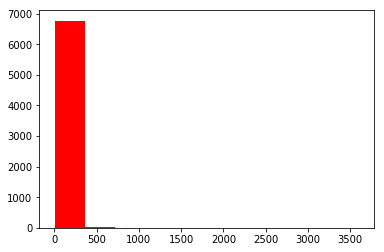

In [24]:
py.hist(physical_term_dist, color='red')

(array([4968., 1075.,  391.,  165.,   71.,   36.,   18.,   14.,   11.,
           8.]),
 array([  1. ,  30.3,  59.6,  88.9, 118.2, 147.5, 176.8, 206.1, 235.4,
        264.7, 294. ]),
 <a list of 10 Patch objects>)

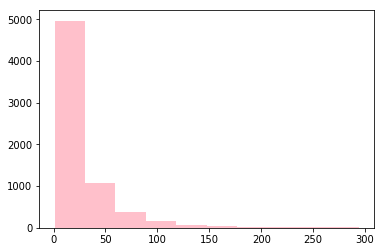

In [25]:
## plot the distribution without the top 10%
physical_no_outlier = np.sort(physical_term_dist)[:-58]
py.hist(physical_no_outlier, color='pink')

(array([644.,  21.,   5.,   5.,   1.,   2.,   0.,   1.,   1.,   1.]),
 array([  64. ,  418.1,  772.2, 1126.3, 1480.4, 1834.5, 2188.6, 2542.7,
        2896.8, 3250.9, 3605. ]),
 <a list of 10 Patch objects>)

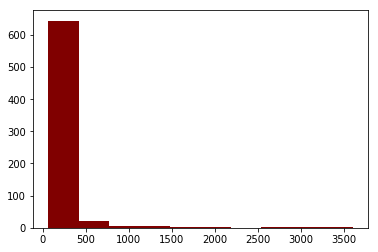

In [26]:
## plot only the top 10% of the terms
physical_top_ten_percent = np.sort(physical_term_dist)[round(len(physical_term_dist)- .1*len(physical_term_dist)):]
py.hist(physical_top_ten_percent, color = 'maroon')

In [41]:
sum(physical_term_dist > 50)

1015

## analysis of genetic interactions

In [28]:
file_genetic = 'genetic_interactions_biogrid_%s.gmt'% str(datetime.date.today())[0:7].replace('-', '_')
genetic_term_dist = write_gmt(genetic_dict, file_genetic)

In [29]:
genetic_term_dist = np.asarray(genetic_term_dist)
len(genetic_term_dist)

5945

In [30]:
genetic_term_dist.mean()

147.39158957106812

In [31]:
genetic_term_dist.std()

171.1027423035584

(array([4.696e+03, 8.460e+02, 2.870e+02, 8.500e+01, 2.600e+01, 3.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 2.2520e+02, 4.4940e+02, 6.7360e+02, 8.9780e+02,
        1.1220e+03, 1.3462e+03, 1.5704e+03, 1.7946e+03, 2.0188e+03,
        2.2430e+03]),
 <a list of 10 Patch objects>)

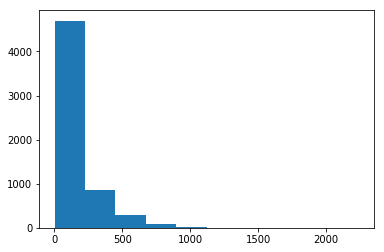

In [32]:
py.hist(genetic_term_dist)

(array([3428., 1117.,  551.,  329.,  223.,  128.,   76.,   42.,   22.,
          16.]),
 array([1.000e+00, 1.022e+02, 2.034e+02, 3.046e+02, 4.058e+02, 5.070e+02,
        6.082e+02, 7.094e+02, 8.106e+02, 9.118e+02, 1.013e+03]),
 <a list of 10 Patch objects>)

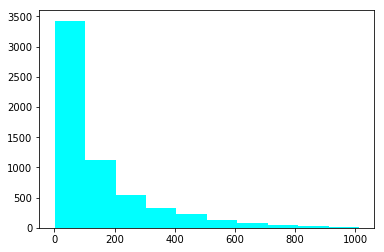

In [33]:
## plot the distribution without the top 10%
genetic_no_outlier = np.sort(genetic_term_dist)[:-13]
py.hist(genetic_no_outlier, color='cyan')

(array([373., 147.,  47.,  23.,   3.,   0.,   0.,   1.,   0.,   1.]),
 array([ 377. ,  563.6,  750.2,  936.8, 1123.4, 1310. , 1496.6, 1683.2,
        1869.8, 2056.4, 2243. ]),
 <a list of 10 Patch objects>)

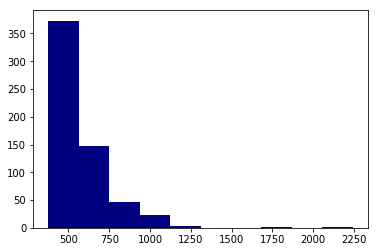

In [34]:
## plot only the top 10% of the terms
genetic_top_ten_percent = np.sort(genetic_term_dist)[round(len(genetic_term_dist)- .1*len(genetic_term_dist)):]
py.hist(genetic_top_ten_percent, color = 'navy')

In [42]:
sum(genetic_term_dist > 50)

4005

## create gmt files for only hubs (> 50 interactors) and elminate some large outliers (> 1000 interactors)

In [56]:
## function write a gmt file from the dictionary and outputs the distribution of genes per term
def write_gmt(Dict, filename):
    
    term_sizes = []
    with open(filename, 'w') as file:
        for key,value in Dict.items():
            
            if len(set(value)) > 50 and len(set(value)) < 1000:
                file.write(str(key).upper() + '\t' + '\t')
                for element in value:
                    file.write(str(element).upper() + '\t')
                file.write('\n')
                term_sizes.append(len(set(value)))
    
    return term_sizes

In [57]:
file_physical = 'physical_interactions_hubs_biogrid_V2_%s.gmt'% str(datetime.date.today())[0:7].replace('-', '_')
physical_term_dist = write_gmt(physical_dict, file_physical) 

In [58]:
file_genetic = 'genetic_interactions_hubs_biogrid_V2_%s.gmt'% str(datetime.date.today())[0:7].replace('-', '_')
genetic_term_dist = write_gmt(genetic_dict, file_genetic)

## get gmt stats for both physical and genetic interaction hub gmts

In [48]:
def getTermStats(loaded_gmt, geneInfoTable, num_samplings, num_genes_in_sampling) :
    # get the relevant terms and set a dictionary for them
    term_set = loaded_gmt.iloc[:,0].apply(lambda x: x.split("\t")[0])
    term_genes_dict = {term_set[i]: loaded_gmt.iloc[i,0].split("\t")[2:] for i in range(0, loaded_gmt.shape[0])}
    term_rank_dict = {k: [] for k in term_set}
    term_stats_dict = {k: [] for k in term_set}
    
    # get the total number of genes in the organism
    n_genes = len(geneInfoTable["Symbol"].unique())
    
    # number of genes per sampling, number of times to sample
    genes_in_sampleing = num_genes_in_sampling
    num_samplings = num_samplings
    
    for i,x in enumerate(range(0,num_samplings)):
        
        progressPercent = ((i+1)/len(range(0,num_samplings)))*100
        
        sys.stdout.write("Progress: %d%%  %d Out of %d   \r" % (progressPercent, (i+1), len(range(0,num_samplings))))
        sys.stdout.flush()
            
        
        randomSet = set(geneInfoTable["Symbol"].sample(genes_in_sampleing).apply(lambda x: x.split('.')[0]))
        
        # initialize an array to hold the pvalue for each term
        pvals = np.array([])
        for key in term_rank_dict.keys():
            
            termSet = set(term_genes_dict[key])
            # calculate p value using fisher exact test
            # implemented using the formula found in the GeneOverap bioconductor package for R
            pval_term = stat.fisher_exact([[n_genes - len(termSet.union(randomSet)), len(randomSet.difference(termSet))], [len(termSet.difference(randomSet)), len(termSet.intersection(randomSet))]])[1]
            pvals = np.append(pvals, [pval_term])
        
        # sort the pvals and add the rank to the term_rank dict
        sorted_pvals = pvals.argsort()
        
        # find the rank for each term by sorting the pvals array and getting the index of the key position in the
        # sorted list. Need to +1 because the index begins with 0
        
        for j,key in enumerate(term_rank_dict.keys()):
            term_rank_dict[key].append(np.where(sorted_pvals == j)[0][0] + 1)
            
    for key in term_rank_dict:
        term_stats_dict[key] = [np.mean(term_rank_dict[key]), np.std(term_rank_dict[key])]
            
    
    
    return term_stats_dict

In [49]:
## load the protein-coding set for sampling
sCerevisiae_geneInfo = pd.read_csv("input/Saccharomyces_cerevisiae.gene_info", sep="\t")
sCerevisiae_proteinCoding = sCerevisiae_geneInfo[sCerevisiae_geneInfo["type_of_gene"] == "protein-coding"]

In [50]:
physical_gmt = pd.read_csv("physical_interactions_hubs_biogrid_V2_2018_07.gmt", sep="~", header=None)
type(physical_gmt)

pandas.core.frame.DataFrame

In [51]:
genetic_gmt = pd.read_csv("genetic_interactions_hubs_biogrid_V2_2018_07.gmt", sep="~", header=None)
type(genetic_gmt)

pandas.core.frame.DataFrame

In [52]:
physical_stats = getTermStats(physical_gmt, sCerevisiae_proteinCoding, 200, 300)

In [53]:
genetic_stats = getTermStats(genetic_gmt, sCerevisiae_proteinCoding, 200, 300)

In [54]:
df_physical_stats = pd.DataFrame.from_dict(physical_stats, orient='index', columns=['mean', 'sd'])
df_genetic_stats = pd.DataFrame.from_dict(genetic_stats, orient='index', columns=['mean', 'sd'])

In [55]:
df_physical_stats.to_csv('output/physical_interactions_hubs_biogrid_V2_2018_07_stats.tsv', sep='\t', header=False)
df_genetic_stats.to_csv('output/genetic_interactions_hubs_biogrid_V2_2018_07_stats.tsv', sep='\t', header=False)